In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import fermi_surface as fs
importlib.reload(fs)
import density_of_states as dos
importlib.reload(dos);

In [4]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_bands = material.read_bandx_raw()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
neutral_electrons = 7

# now start my algorithm to find good matrices
additional_bands = 0
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.005
weights[1] = 0.005
weights[2] = 0.05
weights[3] = 0.5
weights[-1] = 0.005
weights[-2] = 0.05
weights[-3] = 0.5

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (2, 2, 2), (3, 0, 0)) # works well
tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.cubic(True), neighbors, k_smpl, ref_bands, band_offset, additional_bands)
tb_nitinol.normalize()
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4)

# TODO check why this still works but the other code needs a learning rate < 1

#plot_bands_generic(k_smpl, ref_bands, '.')
#tb_nitinol.plot_bands(k_smpl)

loss: 1.17e+00 (max band-error [19.392 15.509  7.229  3.613  1.621  1.177  1.678  1.692  1.526  4.12596])
loss: 8.69e-01 (max band-error [16.549 14.193  6.418  3.717  1.12   0.952  1.149  1.335  0.82   2.416
loss: 8.71e-01 (max band-error [ 9.181  9.824  3.092  1.725  0.809  0.898  1.299  2.7    1.162  2.886
loss: 8.05e-01 (max band-error [15.699 10.327  4.779  2.989  1.251  0.9    1.126  1.344  0.668  2.572
loss: 7.62e-01 (max band-error [12.65  10.869  4.637  2.007  0.799  1.276  0.838  1.433  0.808  1.989
loss: 6.54e-01 (max band-error [10.339  6.976  3.253  2.696  0.777  0.91   0.619  0.942  0.904  0.986
loss: 5.63e-01 (max band-error [9.658 5.693 2.685 1.402 0.834 0.67  0.595 1.058 0.492 1.457 4.898 7.913])
aborted
final loss: 4.79e-01 (max band-error [7.066 4.679 2.512 0.626 0.669 0.509 0.562 0.792 0.771 1.257 3.161 8.144])


In [ ]:
with open("ni.repr", "r") as file:
    H_r_repr = " ".join(file.readlines())
    H_r, neighbors, S, inversion  = eval(H_r_repr.replace("array", "np.array"))
    tb_nitinol = BandStructureModel.init_tight_binding(Symmetry(S, inversion=inversion), neighbors, len(H_r[0]), cos_reduced=True, exp=False)
    tb_nitinol.set_params_complex(H_r)

6.967036124455275 1.3279194085671124
6.967036124455275 1.3279194085671124


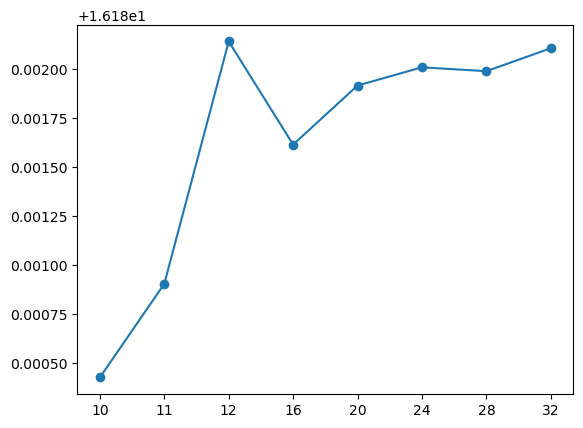

In [6]:
import density_of_states as dos
importlib.reload(dos)
fermi_energy = 16.157
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
states, density = dos_nitinol.states_density(fermi_energy)
print(states, density)
states = dos_nitinol.states_below(fermi_energy)
density = dos_nitinol.density(fermi_energy)
print(states, density)

e_list = []
N_smpl = [10, 11, 12, 16, 20, 24, 28, 32]
for N in N_smpl:
    dos_nitinol = dos.DensityOfStates(tb_nitinol, N=N, ranges=((0.0, 0.5),)*3, wrap=False)
    fermi_energy = dos_nitinol.fermi_energy(neutral_electrons)
    e_list.append(fermi_energy)
plt.plot(e_list, 'o-')
plt.xticks(np.arange(len(N_smpl)), [str(N) for N in N_smpl])
plt.show()

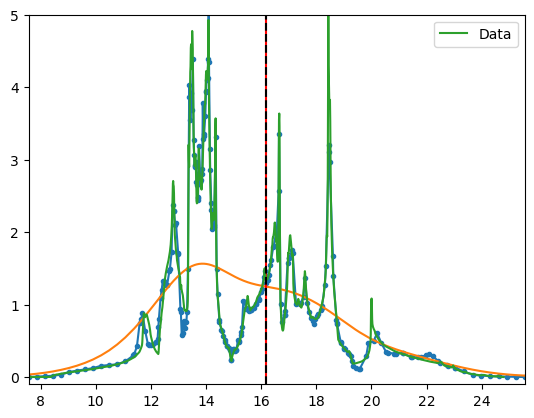

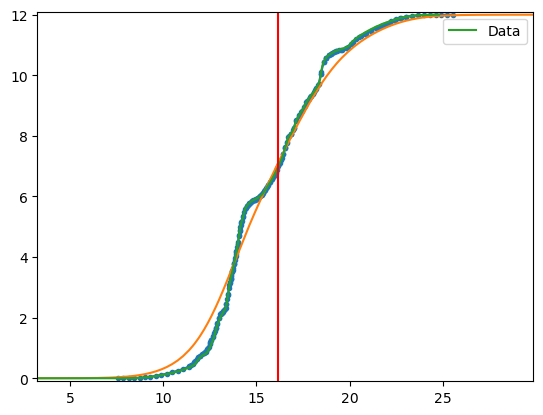

In [81]:
(energy_smpl2, density2, states2), fermi_energy2 = material.read_dos() # Diese Rechnung hat 20min gebraucht!
energy_smpl, states, density = dos_nitinol.full_curve(N=20)
energy_smpl_T, states_T, density_T = dos_nitinol.full_curve(N=20, T=10000)
plt.plot(energy_smpl, density, '.-')
plt.plot(energy_smpl_T, density_T, '-')
plt.axvline(fermi_energy, color='r')
plt.plot(energy_smpl2, density2/2, '-', label="Data")
plt.axvline(fermi_energy, color='k', linestyle="dashed")
plt.ylim(-0.1, 5)
plt.xlim(np.min(energy_smpl), np.max(energy_smpl))
plt.legend()
plt.show()
plt.plot(energy_smpl, states, '.-')
plt.plot(energy_smpl_T, states_T, '-')
plt.plot(energy_smpl2, states2/2-8, '-', label="Data")
plt.axvline(fermi_energy, color='r')
plt.ylim(-0.1, dos_nitinol.model_bandcount()+0.1)
plt.xlim(np.min(energy_smpl_T), np.max(energy_smpl_T))
plt.legend()
plt.show()

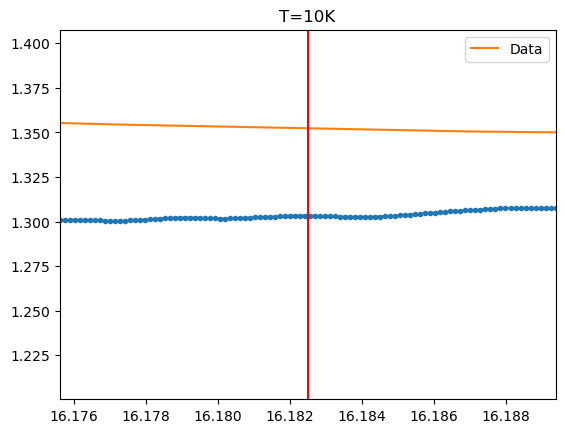

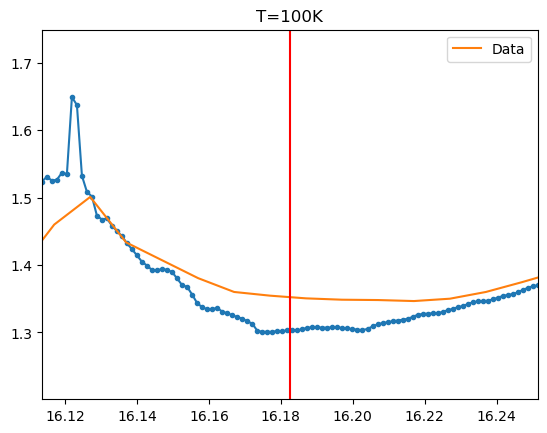

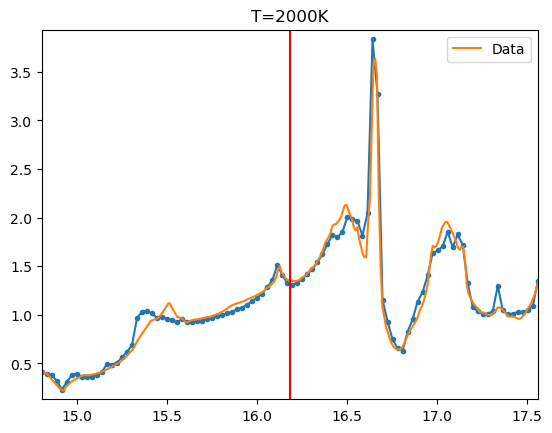

In [82]:
for T in [10, 100, 2000]:
    k_B = 8.61733326214518e-5 # eV/K
    beta = 1 / (k_B * T) # 1/eV
    delta = 8 / beta
    energy_smpl = np.linspace(fermi_energy - delta, fermi_energy + delta, 100)
    density = [dos_nitinol.density(e) for e in energy_smpl]
    plt.plot(energy_smpl, density, '.-')
    plt.plot(energy_smpl2, density2/2, '-', label="Data")
    plt.axvline(fermi_energy, color='r')
    #plt.vlines(np.ravel(dos_nitinol.bands_range), 0.5, 3.7, color='k', linestyle="dashed")
    plt.xlim(fermi_energy - delta, fermi_energy + delta)
    plt.ylim(np.min(density)-0.1, np.max(density)+0.1)
    plt.title(f"T={T}K")
    plt.legend()
    plt.show()

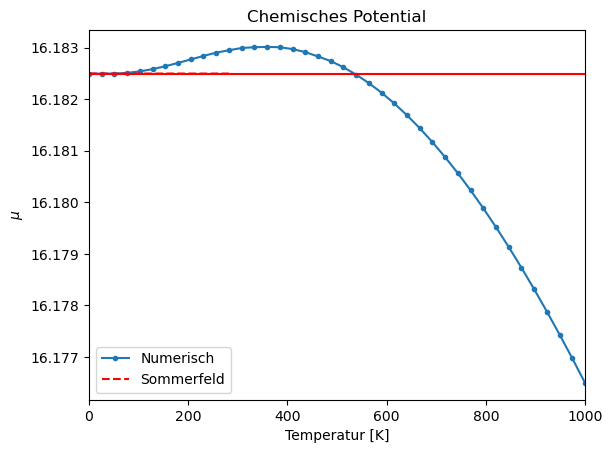

In [87]:
# plot chemical potential in dependence of T

# new method using exact convolution of states
T_smpl = np.linspace(0, 1000, 40)
mu_list = dos_nitinol.chemical_potential(neutral_electrons, T_smpl, N=40, tol=1e-8, maxsteps=50)
e0, e1 = dos_nitinol.energy_range()
T_lin = 0.25*0.25*2/dos.k_B*max(abs(e0-fermi_energy), abs(e1-fermi_energy))
plt.plot(T_smpl, mu_list, '.-', label="Numerisch")

# analytical expectation
plt.axhline(fermi_energy, color="r")
h = 1e-3
drho = (dos_nitinol.density(fermi_energy + h) - dos_nitinol.density(fermi_energy - h)) / 2 / h
rho = dos_nitinol.density(fermi_energy)
plt.plot(T_smpl[T_smpl<300], fermi_energy - drho/rho*np.pi**2/6*dos.k_B**2*T_smpl[T_smpl<300]**2, 'r--', label="Sommerfeld")
plt.plot(T_smpl[T_smpl>T_lin], np.mean(dos_nitinol.bands) - dos.k_B*T_smpl[T_smpl>T_lin]*np.log(len(ref_bands[0])/neutral_electrons-1), color="g")

plt.xlim(np.min(T_smpl), np.max(T_smpl))
plt.title("Chemisches Potential")
plt.ylabel("$\\mu$")
plt.xlabel("Temperatur [K]")
plt.legend()
plt.show()

/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/Library/density_of_states.py:114: RuntimeWarning: divide by zero encountered in divide
  com = np.where(area[...,None] != 0, com / area[...,None], np.reshape((0, 0, 0), shape))
/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/Library/density_of_states.py:114: RuntimeWarning: invalid value encountered in divide
  com = np.where(area[...,None] != 0, com / area[...,None], np.reshape((0, 0, 0), shape))


0.7174070289625946 < 11.879094552301
4682/4682


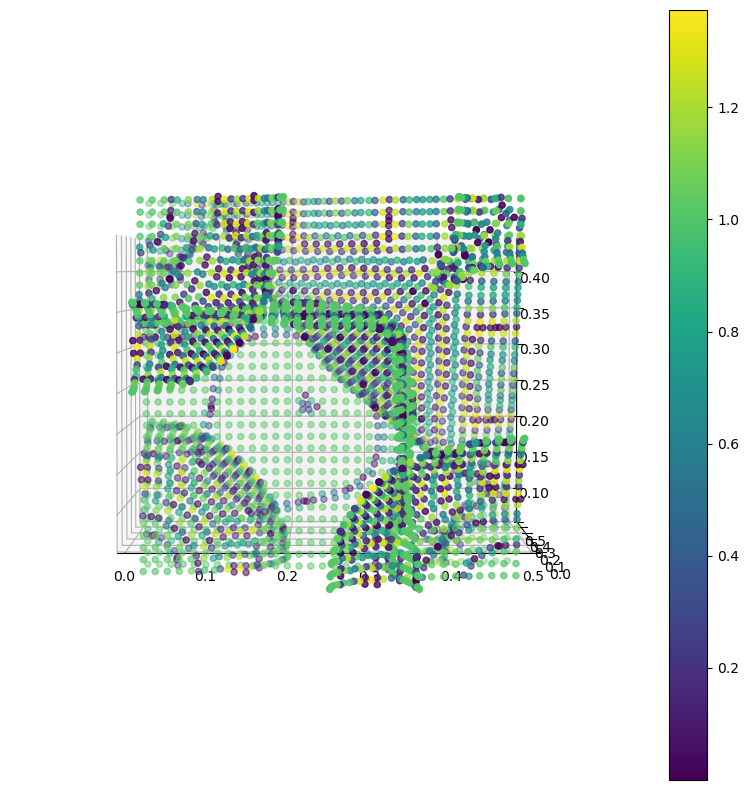

In [97]:
import density_of_states as dos
importlib.reload(dos)
fermi_energy = 16.157
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=32, ranges=((0.0, 0.5),)*3, wrap=False)
#dos_nitinol = dos.DensityOfStates(tb_nitinol, N=24, ranges=((-0.5, 0.5),)*3)

points, weights, area = dos_nitinol.fermi_surface_samples(fermi_energy, improved=True)
print(area, "<", 8 * len(points) * (0.5/32)**2 * 3/4*3**.5)
#assert abs(area - dos_nitinol.density(fermi_energy)) < 1e-5
weights *= len(weights) * area # should be in [0, 1.3]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# plot only the errors...
select = np.min(np.abs(tb_nitinol(points) - fermi_energy), axis=-1) < 1e-2
orig_points_len = len(points)
points = points[select]; weights = weights[select]
print(f"{len(points)}/{orig_points_len}")
cmap = ax.scatter(points[:,0], points[:,1], points[:,2], c=weights)
ax.set_xlim(0.0, 0.5)
ax.set_ylim(0.0, 0.5)
ax.set_zlim(0.0, 0.5)
ax.set_aspect("equal")
#ax.view_init(elev=30, azim=-110)
ax.view_init(elev=2, azim=-90)
plt.colorbar(cmap)
plt.show()

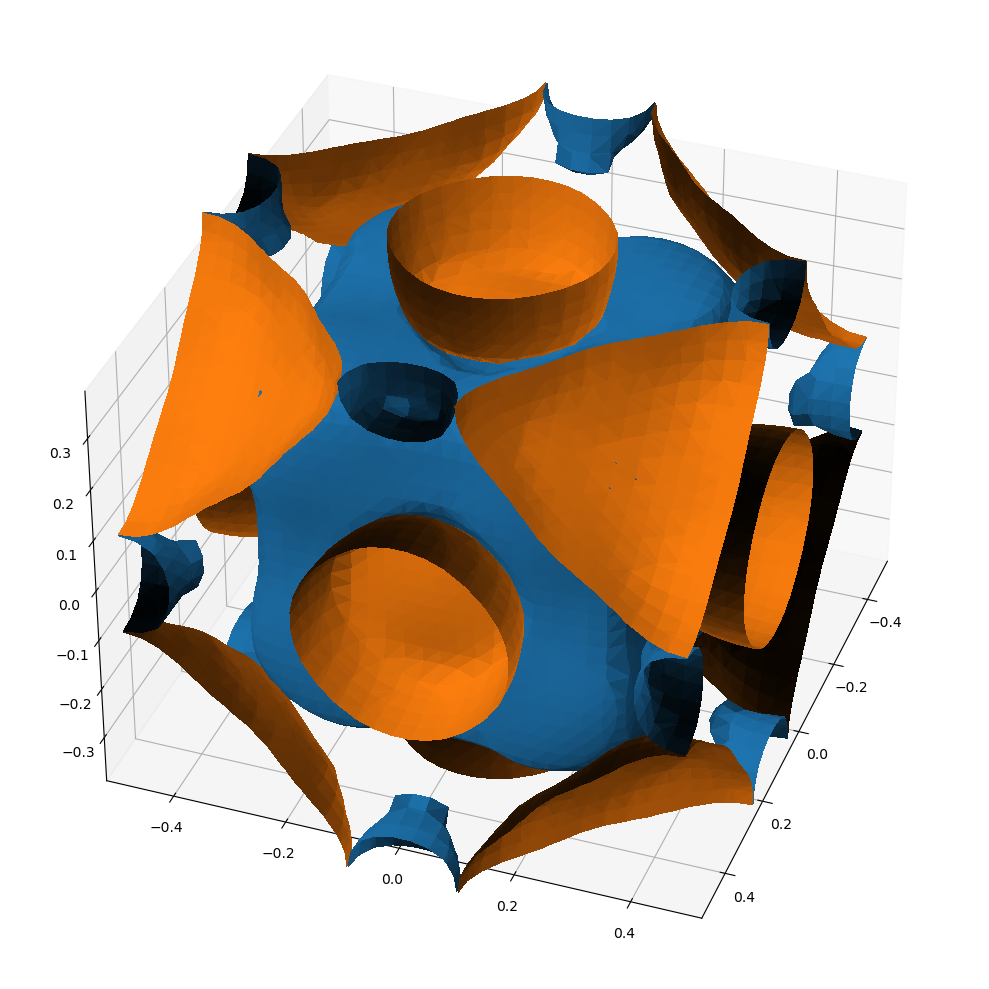

In [36]:
importlib.reload(fs)
# plot the fermi surface
fermi_energy = 16.157
fs.plot_3D_fermi_surface(tb_nitinol, fermi_energy, N=32)